In [10]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import display, HTML

opts = rdMolDraw2D.MolDrawOptions()
#opts.legendFontSize     = 10
opts.annotationFontScale = 1

def annotate_ligand_grid(
    df,
    ligand_col: str = "ligand_name",
    smiles_col: str = "smiles",
    rpos_col: str = "rpos",
    energy_col: str = "dE",
    cols: int = 3,
    subImgSize: tuple = (300, 300)
):
    """
    Group df by ligand_col, annotate each ligand at all its rpos with energy_col,
    and draw them in a grid.

    Returns an RDKit PIL image.
    """
    mols = []
    legends = []
    highlights = []

    for ligand, grp in df.groupby(ligand_col):
        smi       = grp[smiles_col].iloc[0]
        pos_list  = grp[rpos_col].tolist()
        e_list    = grp[energy_col].tolist()

        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            raise ValueError(f"Invalid SMILES for {ligand}: {smi}")

        for pos, e in zip(pos_list, e_list):
            mol.GetAtomWithIdx(pos).SetProp("atomNote", f"{e:.2f}")

        mols.append(mol)
        legends.append(f"{ligand}: " + ", ".join(f"{p}={e:.2f}" for p, e in zip(pos_list, e_list)))
        highlights.append(pos_list)

    grid = Draw.MolsToGridImage(
        mols,
        legends=legends,
        highlightAtomLists=highlights,
        molsPerRow=cols,
        subImgSize=subImgSize,
        maxMols=len(mols),
        returnPNG=False,
        drawOptions=opts
    )
    return grid


def _svg_annotated_smi(
        smi, pos_list, dE_list,
        size=(250, 250), highlight_color=(1, 0, 0)):
    """Return an SVG string of the molecule with per-atom ΔE labels."""

    mol = Chem.MolFromSmiles(smi)
    rdDepictor.Compute2DCoords(mol)

    for p, e in zip(pos_list, dE_list):
        mol.GetAtomWithIdx(int(p)).SetProp("atomNote", f"{e:.2f}")

    drawer = rdMolDraw2D.MolDraw2DSVG(*size)
    opts = drawer.drawOptions()
    opts.drawAtomNotes       = True
    opts.annotationFontScale = 0.9 

    drawer.DrawMolecule(
        mol,
        #highlightAtoms      =[int(p) for p in pos_list],
        #highlightAtomColors ={int(p): highlight_color for p in pos_list},
    )
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

def build_annotated_frame(df,
                          ligand_col="ligand_name",
                          smi_col="smiles",
                          pos_col="rpos",
                          energy_col="dE"):
    """One row per ligand + an SVG column with all ΔE annotations."""
    rows = []
    for lig, grp in df.groupby(ligand_col):
        smi  = grp[smi_col].iloc[0]
        pos  = grp[pos_col].astype(int).tolist()
        dE   = grp[energy_col].tolist()
        svg  = _svg_annotated_smi(smi, pos, dE)
        rows.append({ligand_col: lig, smi_col: smi, "annotated_svg": svg})
    return pd.DataFrame(rows)

In [11]:
conversion_factor       =  627.509474
dimer_dft               = -834847.294
HBpin_dft               = -258305.91711374212
H2_dft                  = -737.1088023791428

dimer_xtb               = -97.050557670754 * conversion_factor
HBpin_xtb               = -28.947535986441 * conversion_factor
H2_xtb                  = -0.9826859256890 * conversion_factor

In [33]:
df_HBpin["xtb-gfn-opt-opt_coords"].to_list()

[array([array([-1.54221981,  1.1396356 , -0.2057067 ]),
        array([-0.74100701, -0.05686967,  0.30271   ]),
        array([-1.40160226, -1.34855482, -0.19494431]),
        array([-0.79180841, -0.09277092,  1.73184432]),
        array([ 0.44229073, -0.39672032,  2.2006014 ]),
        array([ 1.38725703, -0.44161996,  1.23100299]),
        array([0.80248298, 0.00170603, 0.0030788 ]),
        array([ 1.3141895 ,  1.42702337, -0.24008441]),
        array([ 1.27202081, -0.8971546 , -1.13868561]),
        array([-1.44534465,  1.22504484, -1.28468702]),
        array([-2.59027915,  0.9923052 ,  0.04258144]),
        array([-1.21303993,  2.06173334,  0.26202856]),
        array([-0.86903874, -2.21639679,  0.18603227]),
        array([-1.43124004, -1.38230016, -1.27993871]),
        array([-2.41881502, -1.38498837,  0.18844483]),
        array([ 0.66760582, -0.59942517,  3.32219025]),
        array([1.02316493, 2.07809514, 0.58047988]),
        array([ 2.40089753,  1.40105419, -0.27772467])

In [36]:
from tooltoad.vis import MolTo3DGrid
from tooltoad.chemutils import ac2mol

df_HBpin = pd.read_parquet("output_files/HBpin-mol.parquet")
atoms = df_HBpin["atoms"].iloc[0]
coords = df_HBpin["xtb-gfn-opt-opt_coords"].iloc[0]

mol = ac2mol(atoms, coords)
MolTo3DGrid(mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [25]:
import pyarrow.parquet as pq

schema = pq.read_schema("output_files/HBpin-mol.parquet")
#schema.field_by_name

In [13]:
df_lig = pd.read_parquet(
    "output_files/font_ligs.parquet",
    columns=[
        "ligand_name",        
        "orca-wB97X-D3-6-31G**-Freq-electronic_energy",
        "orca-wB97X-D3-6-31G**-Freq-gibbs_energy",
        "orca-wB97X-D3-6-31+G**-NoSym-electronic_energy",
    ],
)
df_ts = pd.read_clipboard()

In [14]:
df_ts

,ligand_name,rpos,energy_g_final,dG(TS1)
15,1-methylpyrrole,2,-573872.036955,23.074336
16,1-methylpyrrole,3,-573871.124956,23.986335
14,"2,3-dihydrothieno[3,4-b][1,4]dioxine",1,-907278.093688,20.472442
7,2-methoxy-1-methylpyrrole,6,-645701.286871,22.498946
8,2-methoxy-1-methylpyrrole,7,-645704.480851,19.304966
17,2-methoxyfuran,3,-633515.120605,20.014060
18,2-methoxyfuran,4,-633508.515011,26.619654
19,2-methoxyfuran,5,-633522.468565,12.666101
4,2-methylfuran,2,-586334.952979,26.712074
5,2-methylfuran,3,-586335.101435,26.563618


In [15]:
df_lig_xtb = pd.read_parquet(
    "output_files/font_ligs.parquet",
    columns=[
        "ligand_name",
        "xtb-gfn-opt-electronic_energy",
    ],
)

df_ts2_xtb = pd.read_parquet(
    "output_files/font_ts1_redo.parquet",
    columns=[
        "ligand_name",
        "rpos",
        "xtb-gfn-opt-electronic_energy",
    ],
)
df_ts2_xtb

,ligand_name,rpos,xtb-gfn-opt-electronic_energy
0,1-methylpyrrole,2,-65.703260
1,1-methylpyrrole,3,-65.698673
2,2-methoxyfuran,3,-70.391865
3,2-methoxyfuran,4,-70.386103
4,2-methoxyfuran,5,-70.400501
5,furan,0,-63.160673
6,furan,1,-63.151970
7,2-methylfuran,2,-66.323611
8,2-methylfuran,3,-66.323615
9,2-methylfuran,4,-66.333652


In [16]:
df_lig_xtb.rename(columns={"xtb-gfn-opt-electronic_energy": "xtb-gfn2-lig_energy"}, inplace=True)

In [17]:
df_ts2_xtb.rename(columns={"xtb-gfn-opt-electronic_energy": "xtb-gfn2-ts2_energy"}, inplace=True)

In [18]:
df_xtb = df_ts2_xtb.merge(df_lig_xtb, how="left", on="ligand_name", suffixes=('_ts', '_lig'))
energy_cols = [col for col in df_xtb.columns if 'energy' in col]
df_xtb[energy_cols] = df_xtb[energy_cols] * conversion_factor
df_xtb = df_xtb[~((df_xtb['ligand_name'] == 'trimethyl(pyrrol-1-yl)silane') & (df_xtb['rpos'] == 4))]
df_xtb

,ligand_name,rpos,xtb-gfn2-ts2_energy,xtb-gfn2-lig_energy
0,1-methylpyrrole,2,-41229.418212,-10785.827458
1,1-methylpyrrole,3,-41226.539790,-10785.827458
2,2-methoxyfuran,3,-44171.562090,-13729.117474
3,2-methoxyfuran,4,-44167.946288,-13729.117474
4,2-methoxyfuran,5,-44176.981501,-13729.117474
5,furan,0,-39633.920395,-9189.895778
6,furan,1,-39628.459662,-9189.895778
7,2-methylfuran,2,-41618.694098,-11179.960296
8,2-methylfuran,3,-41618.696727,-11179.960296
9,2-methylfuran,4,-41624.995158,-11179.960296


In [19]:
df_xtb["dE"] = (2 * (df_xtb["xtb-gfn2-ts2_energy"] - df_xtb["xtb-gfn2-lig_energy"]) - dimer_xtb) / 2

In [20]:
df_ts.rename(columns={"dG(TS1)": "dG"}, inplace=True)

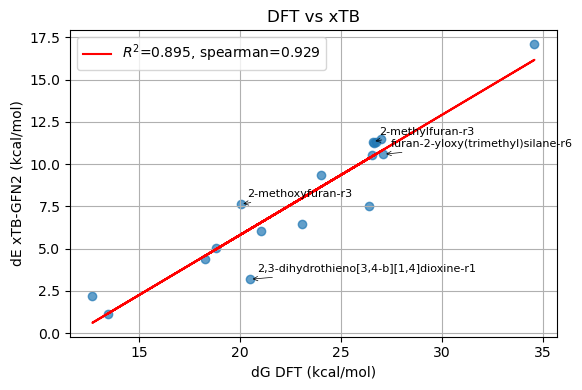

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr

method = 'spearman'  # or 'spearman'

df1 = df_ts[['ligand_name','rpos','dG']].copy()
df2 = df_xtb[['ligand_name','rpos','dE']].copy()
merged = pd.merge(df1, df2, on=['ligand_name','rpos'], how='inner')

x = merged['dG']
y = merged['dE']
slope, intercept, r_val, p_val, stderr = linregress(x, y)
y_fit = slope * x + intercept
rho, _ = spearmanr(x, y)

if method == 'pearson':
    merged['score'] = (y - y_fit).abs()
elif method == 'spearman':
    merged['rank_dG'] = merged['dG'].rank()
    merged['rank_dE'] = merged['dE'].rank()
    merged['score'] = (merged['rank_dE'] - merged['rank_dG']).abs()

outliers = merged.nlargest(2, 'score')

plt.figure(figsize=(6, 4))
plt.scatter(x, y, alpha=0.7)
plt.plot(x, y_fit, color='red', label=f"$R^2$={r_val**2:.3f}, spearman={rho:.3f}")

for _, row in outliers.iterrows():
    lbl = f"{row['ligand_name']}-r{int(row['rpos'])}"
    plt.annotate(lbl, (row['dG'], row['dE']),
                 textcoords="offset points", xytext=(5,5),
                 ha='left', fontsize=8, arrowprops=dict(arrowstyle="->", lw=0.5))

plt.xlabel("dG DFT (kcal/mol)")
plt.ylabel("dE xTB-GFN2 (kcal/mol)")
plt.title("DFT vs xTB")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
merged

,ligand_name,rpos,dG,dE,rank_dG,rank_dE,score
0,1-methylpyrrole,2,23.074336,6.481443,8.0,7.0,1.0
1,1-methylpyrrole,3,23.986335,9.359865,9.0,10.0,1.0
2,"2,3-dihydrothieno[3,4-b][1,4]dioxine",1,20.472442,3.186709,6.0,3.0,3.0
3,2-methoxyfuran,3,20.014060,7.627581,5.0,9.0,4.0
4,2-methoxyfuran,4,26.619654,11.243383,13.0,13.0,0.0
5,2-methoxyfuran,5,12.666101,2.208170,1.0,2.0,1.0
6,2-methylfuran,2,26.712074,11.338395,14.0,15.0,1.0
7,2-methylfuran,3,26.563618,11.335766,12.0,14.0,2.0
8,2-methylfuran,4,18.789064,5.037335,4.0,5.0,1.0
9,2-tert-butylfuran,3,34.589610,17.099286,17.0,17.0,0.0
